In [1]:
from heuristic.trainNetwork import TrainNetwork
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import traceback
from multiprocessing import Pool
from typing import List,Dict,Optional
from pydantic import BaseModel
from random import shuffle
from folium import folium , Marker, PolyLine, CircleMarker
from IPython.display import clear_output

In [2]:
trainNetwork = TrainNetwork()
trainNetwork.load("./heuristic/trainNetwork.save.json")
v = trainNetwork.getRandomVerticesID(2)
samplePath = trainNetwork.breadthFirstSearch(v.get("res")[0],v.get("res")[1]).get("res").get("path")

sampleResult = [trainNetwork.vertices[stationID] for stationID in samplePath ]

sampleCentroid= [
    sum([float(res.get("coordinate").get("lat")) for res in sampleResult])/len(sampleResult),
    sum([float(res.get("coordinate").get("lon")) for res in sampleResult])/len(sampleResult)
]

sampleCoordinate = [ 
    [
        float(res.get("coordinate").get("lat")),
         float(res.get("coordinate").get("lon")) 
    ]
     for res in sampleResult
]

SampleMap = folium.Map(location = sampleCentroid, zoom_start = 12) 
PolyLine(sampleCoordinate,color="red", weight=3.5, opacity=1).add_to(SampleMap)
for i in range(len(sampleCoordinate)):
    CircleMarker(location=sampleCoordinate[i],radius=3,color='red',fill=True,fill_color='red').add_to(SampleMap)
    if(i==0 or i == len(sampleCoordinate)-1):   
        Marker(location= sampleCoordinate[i]).add_to(SampleMap)

SampleMap

loaded edges and vertices


# Particle Swarm Optimization

In [3]:
class Particle:
    def __init__(self,_id:int,distanceGraph:dict,data:List[str],startVerticesID:str,endVerticesID:str):
        self._id = _id
        self.data = [d for d in data if d not in [startVerticesID,endVerticesID]]
        self.startVerticesID = startVerticesID
        self.endVerticesID = endVerticesID
        self.distanceGraph = distanceGraph
        self.velocityGraph = self.initVelocityGraph()
        self.current_state = None
        
    def initVelocityGraph(self):
        velocityGraph = {}
        for fromID in [self.startVerticesID,*self.data,self.endVerticesID]:
            velocityGraph[fromID] = {}
            for toID in [self.startVerticesID,*self.data,self.endVerticesID]:
                velocityGraph[fromID][toID] = 1/(len(self.data)+2)  
        return velocityGraph
        
    def travel(self):
        try:
            # initialization
            unvisited = self.data.copy()
            visited = []
            
            # random walk
            fromID = self.startVerticesID
            while len(unvisited)>0 :
                chance = np.random.rand()
                cummulativeProbablity = 0
                denominator = sum([self.velocityGraph[fromID][toID] for toID in unvisited])
                for toID in unvisited:
                    cummulativeProbablity += self.velocityGraph[fromID][toID]/denominator
                    if cummulativeProbablity > chance:
                        visited.append(toID)
                        unvisited = [ loc for loc in unvisited if loc != toID ]
                        fromID = toID
                        break
                
                        
            path = [self.startVerticesID] + visited + [self.endVerticesID]
            distance = sum([self.distanceGraph[path[i-1]][path[i]] for i in range(1,len(path))])
            result = {"solution":visited, "distance":distance}
            self.current_state = result
            return result,None

        except Exception as error:
            print("traceBack : ",traceback.print_exc())
            return f"{str(error)} ... error at Particle.travel() \n"
        
    def updateVelocity(self,historical_best_state,peer_best_state,inertia=0.8):
        try:
            personalInfluence = np.random.rand()
            socialInfluence = np.random.rand()
            
            # penalty: inertia
            for fromID in self.data:
                for toID in self.data:
                    self.velocityGraph[fromID][toID] *= inertia
            
            # rewards : Personal Influence
            historical_best_path = [self.startVerticesID]+historical_best_state["solution"]+[self.endVerticesID]
            for i in range(1,len(historical_best_path)):
                increment1 = personalInfluence*(1/historical_best_state["distance"]-1/self.current_state["distance"])
                self.velocityGraph[historical_best_path[i-1]][historical_best_path[i]]+= increment1
                
            # rewards : Social Influence
            peer_best_path = [self.startVerticesID]+peer_best_state["solution"]+[self.endVerticesID]
            for i in range(1,len(peer_best_path)):
                increment2 = socialInfluence*(1/peer_best_state["distance"]-1/self.current_state["distance"])
                self.velocityGraph[peer_best_path[i-1]][peer_best_path[i]]+=increment2
            
            
        except Exception as error:
            print("traceBack : ",traceback.print_exc())
            return f"{str(error)} ... error at Particle.updateVelocity() \n"
            

In [4]:
def parallel_travel(p:Particle):
    travelResult,travelErr = p.travel()
    return p, travelResult,travelErr

def parallel_update_velocity(p:Particle,historical_best_state,peer_best_state,inertia):
    updateErr = p.updateVelocity(historical_best_state,peer_best_state,inertia)
    return p, updateErr

class ParticleSwarmOptimizer:
    def __init__(self, graph:TrainNetwork, data:List[str], startVerticesID:str, endVerticesID:str):
        self.graph = graph
        self.data = [d for d in data if d not in [startVerticesID,endVerticesID] ]
        self.startVerticesID = startVerticesID
        self.endVerticesID = endVerticesID
        self.distanceGraph = self.setupDistanceGraph()
        
    def setupDistanceGraph(self):
        locations = [self.startVerticesID] + self.data + [self.endVerticesID]
        distanceGraph = {}
        for fromLoc in locations:
            if  distanceGraph.get(fromLoc) is None:  distanceGraph[fromLoc] = {} 
            for toLoc in locations:
                if fromLoc==toLoc:
                    distanceGraph[fromLoc][toLoc] = 0
                else:
                    travel = self.graph.breadthFirstSearch(fromLoc,toLoc)
                    if(travel.get("err")): raise travel.get("err")
                    distanceGraph[fromLoc][toLoc] =len(travel.get("res").get("path"))
        return distanceGraph
    
    def Train(self,iteration,population:int,inertia=0.8):
        try:
            # Init Variable
            historical_best_record = []
            peer_best_record = []
            iteration_record = []
            historical_best_state = None
            
            # spawn particles
            particles = [
                Particle(
                    p,
                    self.distanceGraph,
                    self.data,
                    self.startVerticesID,
                    self.endVerticesID
                ) 
                for p in range(population)
            ]
            
            # Iteration
            for i in range(iteration):
                peer_best_state = None
                
                particle_pool = []
                with Pool() as pool:
                    pooling_results = pool.map(parallel_travel, particles)
                    for pooling_result in pooling_results: 
                    # Travel Solution Generation
                        p,travelResult,travelErr = pooling_result
                        if travelErr is not None: raise Exception(travelErr)
                        particle_pool = [*particle_pool,p]    
                
                        # Solution Evalution
                        p.current_state
                        if historical_best_state is None: historical_best_state = p.current_state
                        if historical_best_state["distance"] > p.current_state["distance"]: historical_best_state = p.current_state
                        if peer_best_state is None: peer_best_state = p.current_state
                        if peer_best_state["distance"] > p.current_state["distance"]: peer_best_state = p.current_state
                            
                particles = particle_pool
#                 for p in particles: 
                # Update Velocity Learning
                particle_pool_after_update = []
                parallel_update_velocity_param = [(p,historical_best_state,peer_best_state,inertia) for p in particle_pool]
                with Pool() as pool:
                    pooling_update_results = pool.starmap(parallel_update_velocity, parallel_update_velocity_param)
#                     updateErr = p.updateVelocity(historical_best_state,peer_best_state,inertia)
#                     if updateErr is not None: raise Exception(updateErr)
                    for pooling_update_result in pooling_update_results:
                        p,updateErr = pooling_update_result
                        if updateErr is not None: raise Exception(updateErr)
                        particle_pool_after_update = [*particle_pool_after_update,p]
                        
                particles = particle_pool_after_update
                # Reporting
                peer_best_record.append(peer_best_state["distance"])
                historical_best_record.append(historical_best_state["distance"])
                iteration_record.append(i)
                
                # Plot graph
                clear_output(wait=True)
                plt.xlabel('iteration')
                plt.ylabel('number of station used')
                plt.plot(iteration_record, peer_best_record, label="social influence")
                plt.plot(iteration_record, historical_best_record,  label="personal influence")
                plt.legend()
                plt.show()
            
            res = [historical_best_state,*[p.current_state for p in particles]]
            res.sort(key=lambda r : r["distance"])
            res = [ 
                {
                    "distance": sol.get("distance"),
                    "solution": [self.startVerticesID,*sol.get("solution"),self.endVerticesID]
                } 
                for sol in res]
            return res, None
        except Exception as error:
            print("traceBack : ",traceback.print_exc())
            return None,f"{str(error)} ... error at ParticleSwarmOptimizer.Train() \n"
        

# Generation Test Data

In [5]:
stationIDs = trainNetwork.getRandomVerticesID(10).get("res")
# stationIDs = ['PY19', 'SP1', 'PY15', 'KJ11', 'SP24', 'AG18', 'AG17', 'PY29', 'PY03', 'PY07']
# stationIDs = ['AG16','KJ35','AG11','PY21','AG1','PY27','PY22','KG33','KJ5','KJ9','SP8','KJ19','AG6','KG17','AG7','KG34','PY37','SP4','SP14','KJ6']
pd.DataFrame([trainNetwork.vertices[stationID] for stationID in stationIDs])

,id,stationName,coordinate
0,KJ5,Setiawangsa,"{'lat': '3.1756', 'lon': '101.735735'}"
1,PY05,Damansara Damai,"{'lat': '3.19978', 'lon': '101.59268'}"
2,AG11,Chan Sow Lin,"{'lat': '3.1278462', 'lon': '101.7155894'}"
3,SP11,Chan Sow Lin,"{'lat': '3.1278462', 'lon': '101.7155894'}"
4,KJ31,USJ 7,"{'lat': '3.05496', 'lon': '101.59219'}"
5,SP24,IOI Puchong Jaya,"{'lat': '3.0480756', 'lon': '101.6209657'}"
6,SP18,Sri Petaling,"{'lat': '3.06144', 'lon': '101.68707'}"
7,PY14,Kentonmen,"{'lat': '3.19549', 'lon': '101.67963'}"
8,SP21,Alam Sutera,"{'lat': '3.0546753', 'lon': '101.6565324'}"
9,PY16,Sentul Barat,"{'lat': '3.17906', 'lon': '101.68519'}"


# Model Fitting

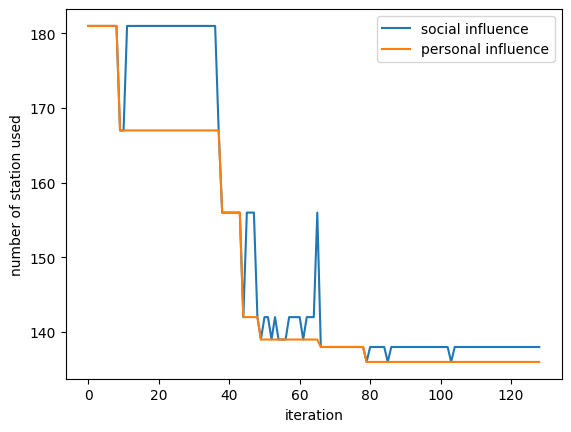

In [ ]:
start = stationIDs[0]
end = stationIDs[0] #stationIDs[len(stationIDs)-1]

# Hyperparameter
populationSize=len(stationIDs)
iteration=300
inertia = 0.95

#Model
pso = ParticleSwarmOptimizer(trainNetwork,stationIDs,start,end)
solution,err = pso.Train(iteration, populationSize, inertia)
if(err is not None): print(err)

# Result of Each Particles

In [ ]:
result = [ s for s in solution ]
pd.DataFrame(result)

# Best Particle Proposed Solution

In [ ]:
soln = [trainNetwork.vertices.get(stationID) for stationID in result[0].get("solution")]
pd.DataFrame(soln)

# Map visualization

In [ ]:
stations = result[0].get("solution")
paths = []
for i in range(len(stations)):
    if i > 0:
        from_id = stations[i-1]
        to_id = stations[i]
        travelRes = trainNetwork.breadthFirstSearch(fromID=from_id,toID=to_id)
        if(travelRes.get("err")) : print(travelRes)
        paths.append(travelRes.get("res").get("path"))

# print({"from":stations[0],"to":stations[len(stations)-1]})
allPath = []
for path in paths:
    path.pop()
    allPath+=path

In [ ]:
pathData = [trainNetwork.vertices[stationID] for stationID in allPath]
locations = [
    {
        "location":[
            float(path_data.get("coordinate").get("lat")),
            float(path_data.get("coordinate").get("lon"))
        ],
        "popup":path_data.get("stationName")
    }
    for path_data in pathData
]

lat = 0
lon = 0
points = []
for loc in locations:
    lat += loc.get("location")[0]
    lon += loc.get("location")[1]
    points.append(loc.get("location"))
centrold = [lat/len(locations),lon/len(locations)]

Map =  folium.Map(location=centrold, zoom_start = 12)
PolyLine(points,color="red", weight=3.5, opacity=1).add_to(Map)

for loc in locations:
     CircleMarker(
        location=loc.get("location"),
        popup=loc.get("popup"),
        radius=3,
        color='red',
        fill=True,
        fill_color='red'
   ).add_to(Map)
        
for i in range(len(stations)):
    node = trainNetwork.vertices.get(stations[i])
    Marker(
        location=[
            float(node.get("coordinate").get("lat")),
            float(node.get("coordinate").get("lon"))
        ], 
        popup=f'{str(i+1)} - {node.get("stationName")}',
    ).add_to(Map)
    
     
Map